In [60]:
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import TimeDistributed

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical

import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm as log_progress

In [4]:
#load and clean data
MODEL_NAME = "Test"
#MODEL_NAME = 'shakespear2.0'
data_file_name = "data.txt"
SEQUENCE_LENGTH = 1 #how many items are fed into the ai per sequence

raw = open("data/" + data_file_name, "r", encoding='utf-8')

lines = []
print("Loading data...")
for line in log_progress(raw):
    if str(line) != '\n':
        lines.append(str(line))

print("Tokenizing...")
#putting the entirety of the input data into one string
text = ""
for line in log_progress(lines):
    text += line
#tokenizer = RegexpTokenizer(r'[a-zA-Z]')
tokenizer = RegexpTokenizer(r'\w+')
#tokenized = tokenizer.tokenize(text)
tokenized = [item for item in text]

#converting the text into numbers to be processed by the embedding layer of the model
words = [] #one of each word in tokenized will be in here
filtering = lambda x : not x in words #for finding if the word should be added to the words array
find = lambda x : float(words.index(x)) if x in words else float(len(words)) #convert each word into a number. -1 means that the item isn't in the vocabulary
normalize = lambda x: [find(i)/len(words) for i in x]

def convert_to_array(word_arr):
    out = []
    for i in range(len(word_arr)):
        arr = [0] * (len(words)+1)
        arr[i] = 1
        out.append(arr)
    return out
    
print("Finding every unique word...")
for word in log_progress(tokenized):
    if filtering(word):
        words.append(word)

#x data is every single word in the data set, in order
#y data is every single word that comes after the corresponding x value
x = []
y = []
print("Compiling dataset...")
for i in log_progress(range(int(len(tokenized) - SEQUENCE_LENGTH))):
    #x.append(convert_to_array(tokenized[i:i+SEQUENCE_LENGTH]))
    
    x.append(normalize(tokenized[i:i+SEQUENCE_LENGTH]))
    y.append(find(tokenized[i+SEQUENCE_LENGTH]))

x = np.asarray(x, np.float32)
y = np.asarray(y, np.float32)

x = np.reshape(x, (x.shape[0], 1, SEQUENCE_LENGTH))
y = to_categorical(y)

print(x.shape)
print(y.shape)

vocab_size = len(words)

Loading data...



Tokenizing...



Finding every unique word...



Compiling dataset...



(99919, 1, 1)
(99919, 62)


In [71]:
#create and compile model
model = Sequential()

model.add(LSTM(128, input_shape=(1, SEQUENCE_LENGTH)))
model.add(Dropout(0.3))

model.add(Dense(y.shape[1], activation='softmax'))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy')
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 62)                7998      
Total params: 74,558
Trainable params: 74,558
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/5
1406/1406 [==============================] - 9s 7ms/step - loss: 2.9506 - val_loss: 2.9477
Epoch 2/5
1406/1406 [==============================] - 9s 7ms/step - loss: 2.9462 - val_loss: 2.9435
Epoch 3/5
1406/1406 [==============================] - 9s 7ms/step - loss: 2.9431 - val_loss: 2.9392
Epoch 4/5
1406/1406 [==============================] - 9s 7ms/step - loss: 2.9382 - val_loss: 2.9345
Epoch 5/5
1406/1406 [==============================] - 9s 7ms/step - loss: 2.9344 - val_loss: 2.9296


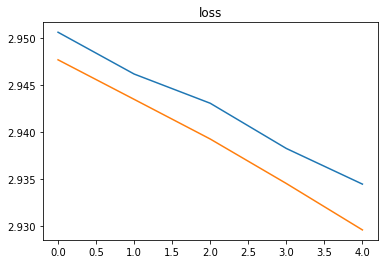

KeyError: 'accuracy'

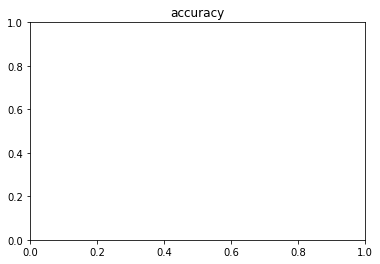

In [52]:
#train model
hist = model.fit(x, y, epochs=5, verbose=1, batch_size=64, shuffle=False, validation_split=0.1)
model.save(MODEL_NAME + ".h5")

plt.title("loss")
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.show()

In [31]:
#test model
sample_length = 200
model = load_model("Test.h5")

#get input sentence and process
sentence = input("Enter first " + str(SEQUENCE_LENGTH) + " words...").lower()

def process(data):
    output = normalize([data])
    output = np.asarray(output, np.float32)
    output = np.reshape(output, (output.shape[0], 1, SEQUENCE_LENGTH))
    return output

root = [item for item in sentence]
root = normalize(root)
root = np.asarray(root, np.float32)
root = np.reshape(root, (root.shape[0], 1, SEQUENCE_LENGTH))

last_input = root[root.shape[0]-1]

output = sentence
pred = model.predict(root)

for i in log_progress(range(sample_length)):
    root = [item for item in output]
    root = normalize(root)
    root = np.asarray(root, np.float32)
    root = np.reshape(root, (root.shape[0], 1, SEQUENCE_LENGTH))
    pred = model.predict(root)
    output += words[pred[pred.shape[0]-1].argmax()]
    
    '''
    next_word = words[pred[pred.shape[0]-1].argmax()]
    output += next_word
    last_input = process(next_word)
    pred = model.predict(last_input)
    '''

print(output)

Enter first 1 words...god fucking damn it



god fucking damn it                                                                                                                                                                                                        


In [ ]:
output = sentence + " "
for i in log_progress(range(sample_length)):
    tmp = np.array(root)
    tmp = np.reshape(tmp, (1, 1, SEQUENCE_LENGTH))
    pred = model.predict(tmp, verbose=0)
    next_word = pred.argmax()
    #next_word = np.random.choice(len(pred[0]), p=pred[0])
    output += words[next_word]
    root.pop(0)
    root.append(next_word) #setting the next word
'np.argmax(model.predict(x), axis=-1)'